In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mahotas
from skimage.measure import shannon_entropy
import imgaug.augmenters as iaa
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.preprocessing import LabelBinarizer

Loading images from directory: Hemorrhagic
Processing image: Hemorrhagic\C010.jpg
Added features for Hemorrhagic: Haralick - [0.1471326743071707, 161.95428162260325, 0.9415884629878474, 1386.2845420916046, 0.5527032203254488, 73.72346618173789, 5383.183886743818, 5.324692136907711, 7.4122721078953155, 0.0010734397843595869, 3.1930235680171655, -0.4189405126785585, 0.9853114097812583], Entropy - 4.669302908353787
Processing image: Hemorrhagic\C010.png
Added features for Hemorrhagic: Haralick - [0.22325666020734516, 185.65908190110179, 0.979396315306003, 4503.871015494939, 0.5864561418341105, 112.13316729978092, 17829.82498007865, 5.420426855822506, 7.444640908449203, 0.0012505811325039386, 3.1793494811399907, -0.47966698110670924, 0.9934300564943092], Entropy - 4.872272563001995
Processing image: Hemorrhagic\C0101.png
Added features for Hemorrhagic: Haralick - [0.02821823834170312, 420.0144125528496, 0.9657413744538821, 6134.324553713616, 0.37678649745399945, 197.4548703026033, 24117.28

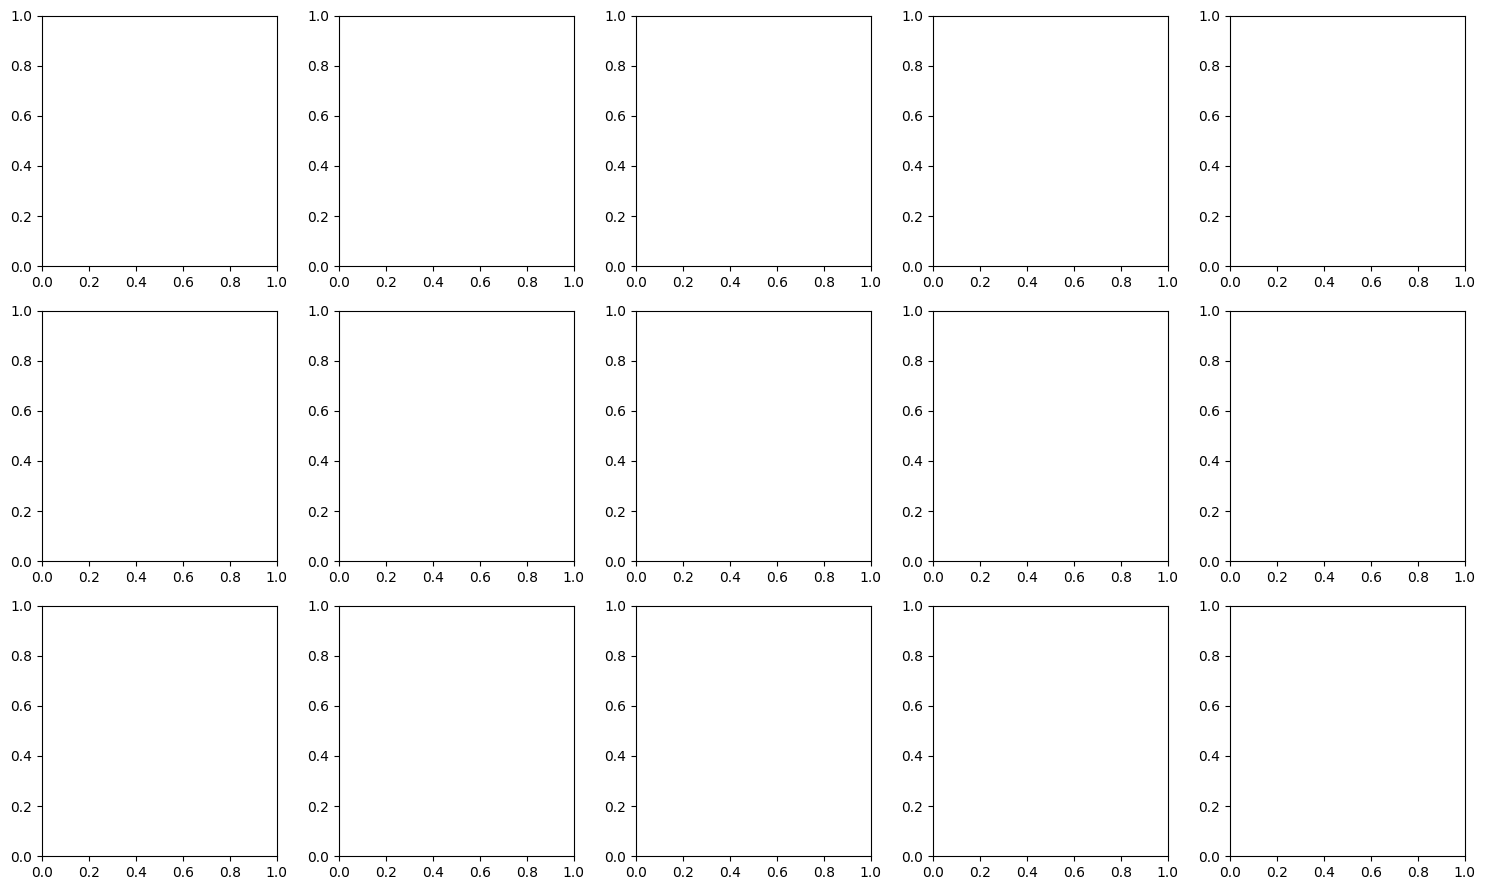

Label: Hemorrhagic, Haralick: [0.1471326743071707, 161.95428162260325, 0.9415884629878474, 1386.2845420916046, 0.5527032203254488, 73.72346618173789, 5383.183886743818, 5.324692136907711, 7.4122721078953155, 0.0010734397843595869, 3.1930235680171655, -0.4189405126785585, 0.9853114097812583], Entropy: 4.67
Label: Ishemic, Haralick: [0.42572511842584776, 152.4393001137594, 0.9648694859023881, 2167.9720896553617, 0.7369705059087074, 53.636476173831156, 8519.44905850769, 3.493554725963542, 4.713181590322275, 0.0019537066294938225, 2.279251674944773, -0.46419505152548124, 0.9636713179434698], Entropy: 3.05
Label: Normal, Haralick: [0.05154084294823814, 498.6548373503068, 0.9419082233091254, 4290.591594424976, 0.5366518641778202, 110.66576612051982, 16663.7115403496, 6.332875625383062, 8.50693161201783, 0.0009773719080675267, 3.5153710475440536, -0.46128501932377675, 0.9951741472896514], Entropy: 5.52


In [7]:
# Normalize image
def normalize_image(img):
    return img / 255.0

# Function to resize images
def preprocess_image(image_path, target_size=(224, 224)):  # Change target_size to (224, 224) for ResNet50
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
    img_resized = cv2.resize(img, target_size)  # Resize image
    img_resized = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB)  # Convert grayscale image to RGB
    return img_resized

# Define a sequence of augmentation techniques
augmenters = iaa.Sequential([
    iaa.Fliplr(0.5),  # Horizontal flip
    iaa.Affine(rotate=(-20, 20)),  # Random rotations between -20 and 20 degrees
    iaa.Affine(scale=(0.8, 1.2)),  # Random zoom in and out
    iaa.AdditiveGaussianNoise(scale=(0, 0.05*255)),  # Add Gaussian noise
    iaa.Crop(percent=(0, 0.1))  # Randomly crop images
])

# Function for data augmentation
def augment_image(image):
    image_aug = augmenters(image=image)
    return image_aug

# Function for feature extraction
def extract_features(image):
    # Calculate Haralick features
    haralick_features = mahotas.features.haralick(image.astype(np.uint8)).mean(axis=0)
    
    # Calculate entropy
    entropy = shannon_entropy(image)
    
    return {
        'haralick': haralick_features.tolist(),  # Convert to list
        'entropy': entropy
    }

# Directory paths
directories = {
    "Hemorrhagic": "Hemorrhagic",
    "Ishemic": "Ishemic",
    "Normal": "Normal"
}

# Load and preprocess the dataset
def load_dataset(directories):
    images = []
    labels = []
    image_paths = []  # Store image paths
    features_list = []  # Initialize an empty list for features
    label_map = {"Hemorrhagic": 0, "Ishemic": 1, "Normal": 2}
    for label, directory in directories.items():
        print(f"Loading images from directory: {directory}")
        for root, _, files in os.walk(directory):
            for file in files:
                if file.endswith('.jpg') or file.endswith('.png'):
                    image_path = os.path.join(root, file)
                    print(f"Processing image: {image_path}")
                    img = preprocess_image(image_path)  # Preprocess image
                    if img is not None:
                        images.append(img)  # Store image
                        labels.append(label_map[label])
                        image_paths.append(image_path)  # Store image path
                        
                        # Extract features if needed
                        features = extract_features(img)  # Extract features
                        features_list.append({'label': label, 'haralick': features['haralick'], 'entropy': features['entropy']})  # Store feature dictionary
                        
                        # Debug: Print the features being added
                        print(f"Added features for {label}: Haralick - {features['haralick']}, Entropy - {features['entropy']}")
                    else:
                        print(f"Unable to load image: {image_path}")
                    
    return images, labels, image_paths, features_list  # Return image paths along with images, labels, and features

# Load and preprocess the dataset
images, labels, image_paths, features_list = load_dataset(directories)

# Display images and features for each folder
def display_images(images, labels, num_images_per_category=5):
    categories = ["Hemorrhagic", "Ishemic", "Normal"]
    fig, axes = plt.subplots(len(categories), num_images_per_category, figsize=(num_images_per_category * 3, len(categories) * 3))  # Create a figure with rows for each category and num_images columns
    
    img_count = {category: 0 for category in categories}
    for i, img in enumerate(images):
        label = labels[i]
        print(f"Image {i + 1} - Label: {label}, Shape: {img.shape}")  # Debug: Print image label and shape
        if label in img_count and img_count[label] < num_images_per_category:  # Check if label exists in img_count
            ax = axes[categories.index(label), img_count[label]]
            ax.imshow(img, cmap='gray')
            ax.set_title(f"Label: {label}")
            ax.axis('off')
            img_count[label] += 1
    
    plt.tight_layout()
    plt.show()
    
    # One-hot encode the labels
def one_hot_encode(labels):
    label_binarizer = LabelBinarizer()
    labels_onehot = label_binarizer.fit_transform(labels)
    return labels_onehot

# Display the first few images with labels
display_images(images, labels)

# Display the first 5 features from each category
categories_displayed = set()
for feature in features_list:
    if feature['label'] not in categories_displayed:
        print(f"Label: {feature['label']}, Haralick: {feature['haralick']}, Entropy: {feature['entropy']:.2f}")
        categories_displayed.add(feature['label'])
        if len(categories_displayed) == 3:
            break

# One-hot encode the labels
labels_onehot = one_hot_encode(labels)
    # One-hot encode the labels
labels_onehot = one_hot_encode(labels)

In [8]:


# Split dataset into train, validation, and test sets
train_images, test_images, train_labels, test_labels = train_test_split(images, labels_onehot, test_size=0.2, random_state=42)
val_images, test_images, val_labels, test_labels = train_test_split(test_images, test_labels, test_size=0.5, random_state=42)

# Load pre-trained ResNet50 model
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in ResNet50
for layer in resnet_model.layers:
    layer.trainable = False

# Create a new model with ResNet50 base
model = Sequential()
model.add(resnet_model)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    np.array(train_images), np.array(train_labels),
    validation_data=(np.array(val_images), np.array(val_labels)),
    epochs=20,
    batch_size=32
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(np.array(test_images), np.array(test_labels))
print(f"Test accuracy: {test_accuracy * 100:.2f}%")




Epoch 1/20


12/12 [==============================] - 39s 3s/step - loss: 20.9808 - accuracy: 0.4905 - val_loss: 9.2064 - val_accuracy: 0.6087
Epoch 2/20
12/12 [==============================] - 37s 3s/step - loss: 7.7609 - accuracy: 0.7166 - val_loss: 1.7453 - val_accuracy: 0.8261
Epoch 3/20
12/12 [==============================] - 37s 3s/step - loss: 2.3555 - accuracy: 0.8120 - val_loss: 0.9192 - val_accuracy: 0.7174
Epoch 4/20
12/12 [==============================] - 37s 3s/step - loss: 0.9683 - accuracy: 0.8365 - val_loss: 0.5388 - val_accuracy: 0.8478
Epoch 5/20
12/12 [==============================] - 38s 3s/step - loss: 0.3886 - accuracy: 0.8774 - val_loss: 0.5001 - val_accuracy: 0.8478
Epoch 6/20
12/12 [==============================] - 38s 3s/step - loss: 0.3087 - accuracy: 0.8747 - val_loss: 0.4314 - val_accuracy: 0.8478
Epoch 7/20
12/12 [==============================] - 37s 3s/step - loss: 0.2594 - accuracy: 0.8556 - val_loss: 0.5892 - val_accuracy: 0.7826
Epoch 8/20
12/

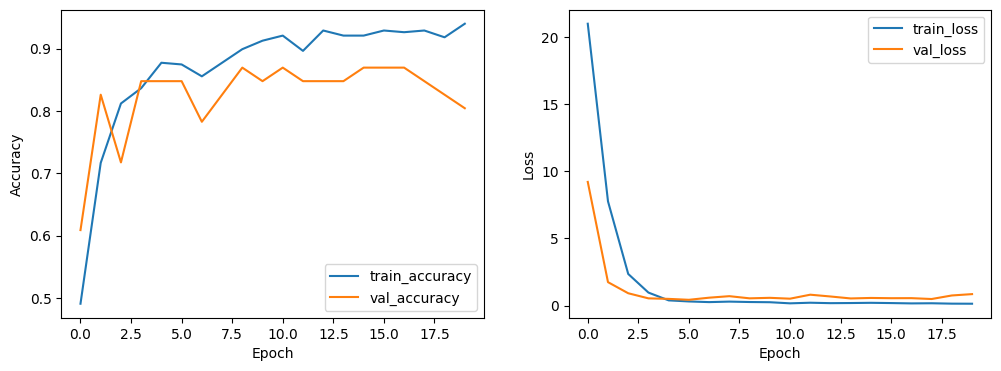

In [9]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

2/2 [==============================] - 5s 1s/step


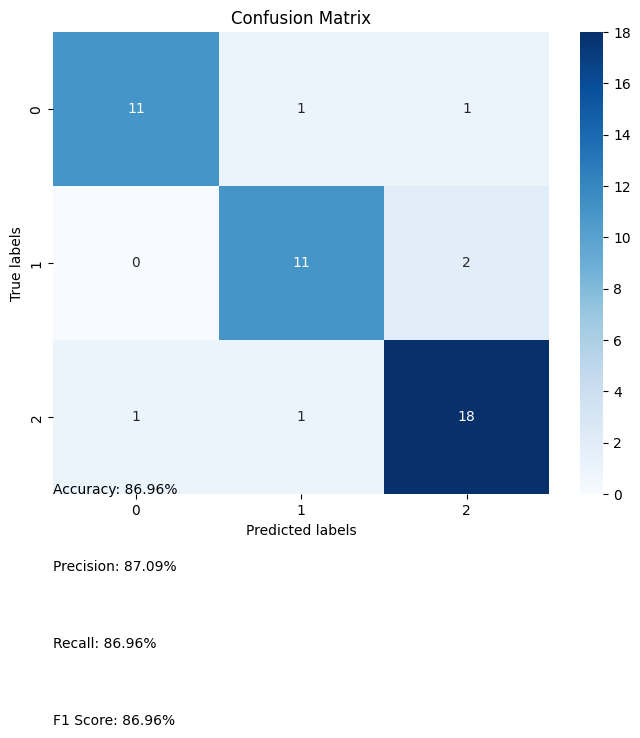

In [10]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Get the predicted labels for the test set
predicted_labels = model.predict(np.array(test_images))
predicted_labels = np.argmax(predicted_labels, axis=1)

# Convert one-hot encoded test labels back to categorical labels
true_labels = np.argmax(test_labels, axis=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels) * 100
precision = precision_score(true_labels, predicted_labels, average='weighted') * 100
recall = recall_score(true_labels, predicted_labels, average='weighted') * 100
f1 = f1_score(true_labels, predicted_labels, average='weighted') * 100

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

# Add accuracy, precision, recall, and F1 score to plot
plt.text(0, 3, f'Accuracy: {accuracy:.2f}%', fontsize=10, ha='left')
plt.text(0, 3.5, f'Precision: {precision:.2f}%', fontsize=10, ha='left')
plt.text(0, 4, f'Recall: {recall:.2f}%', fontsize=10, ha='left')
plt.text(0, 4.5, f'F1 Score: {f1:.2f}%', fontsize=10, ha='left')

plt.show()